In [1]:
from pathlib import Path

import rasterio as rio
import matplotlib.pyplot as plt
from rasterio.warp import Resampling
from rasterio.transform import array_bounds

import eda as eda
from luts import ice_zones, ice_years, data_sources
from config import INPUT_FLAT_DIR, DAILY_BEAUFORT_DIR, DAILY_CHUKCHI_DIR

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/1996-97
All metadata conforms.


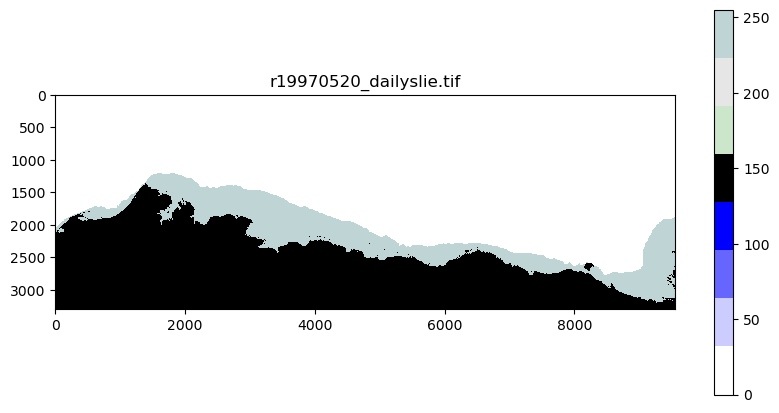

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/1997-98
All metadata conforms.


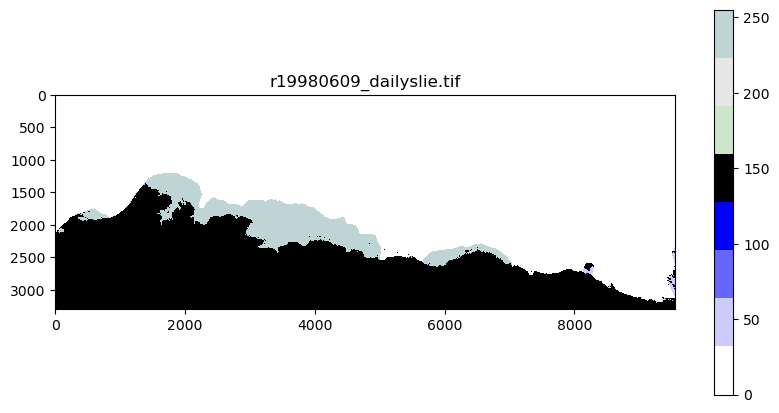

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/1998-99
All metadata conforms.


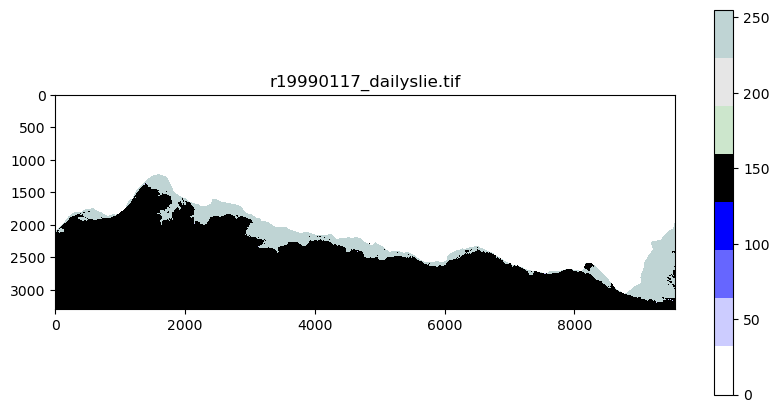

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/1999-00
All metadata conforms.


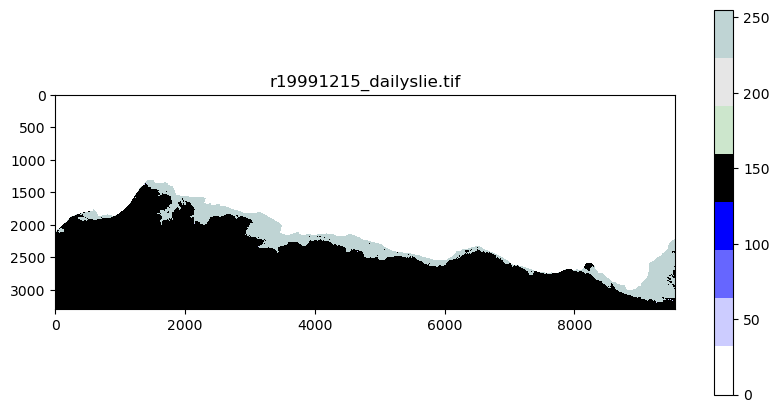

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2000-01
All metadata conforms.


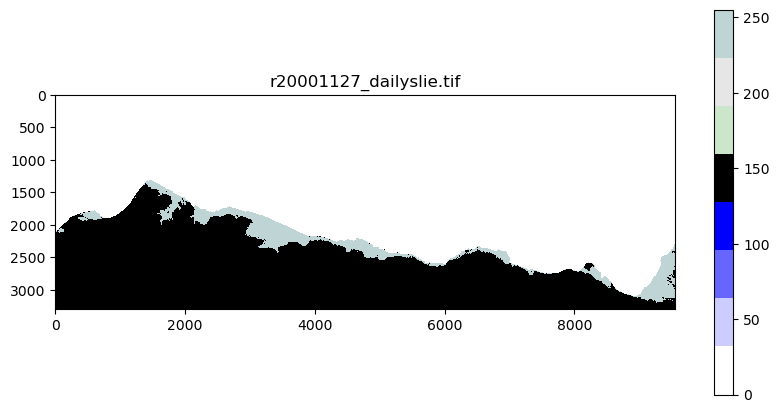

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2001-02
All metadata conforms.


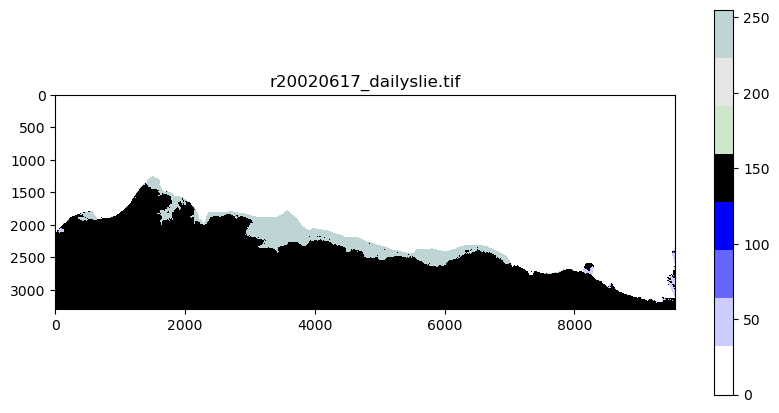

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2002-03
All metadata conforms.


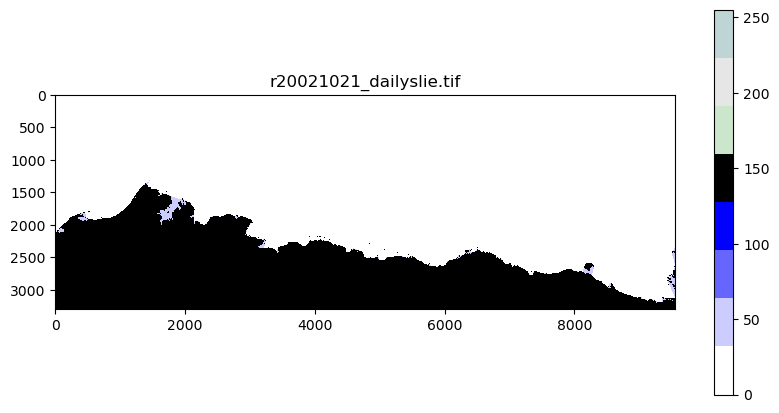

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2003-04
All metadata conforms.


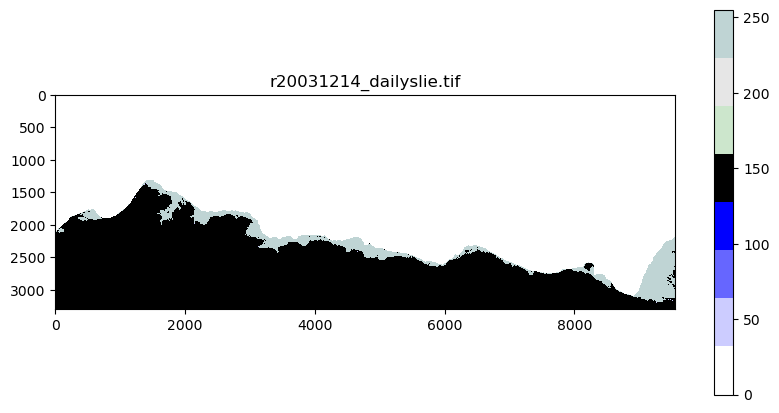

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2004-05
All metadata conforms.


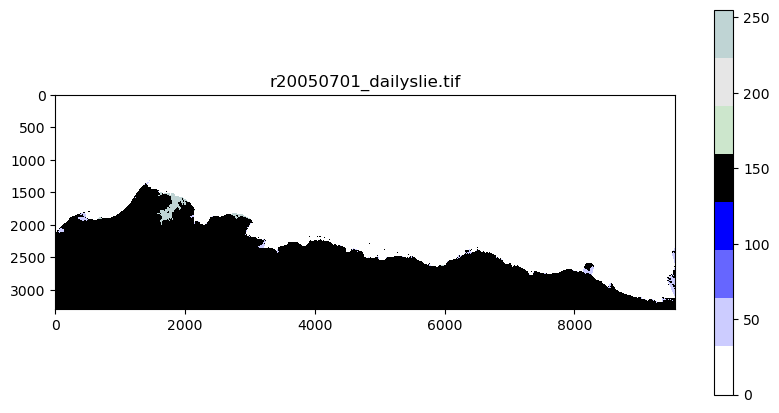

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2005-06
All metadata conforms.


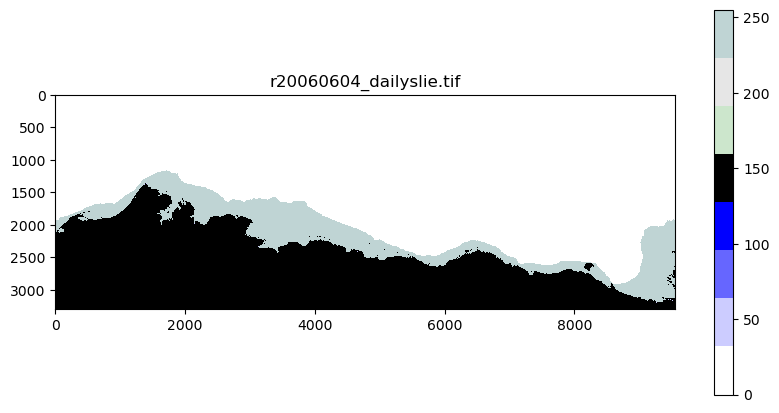

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2006-07
All metadata conforms.


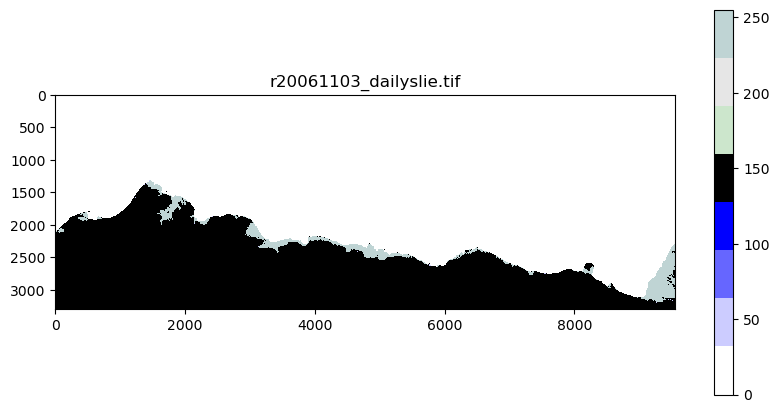

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2007-08
All metadata conforms.


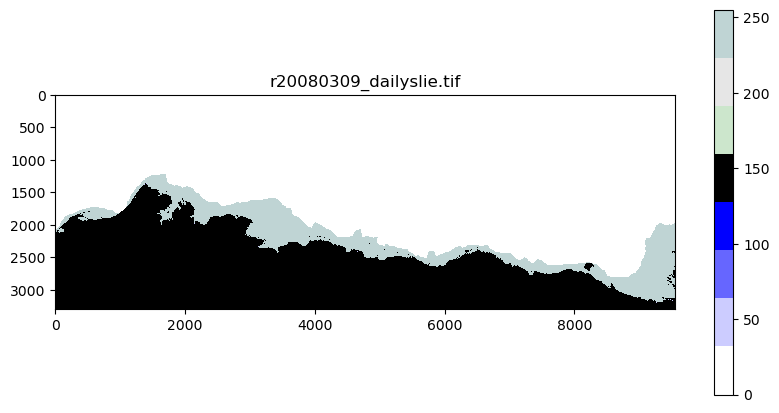

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2008-09
All metadata conforms.


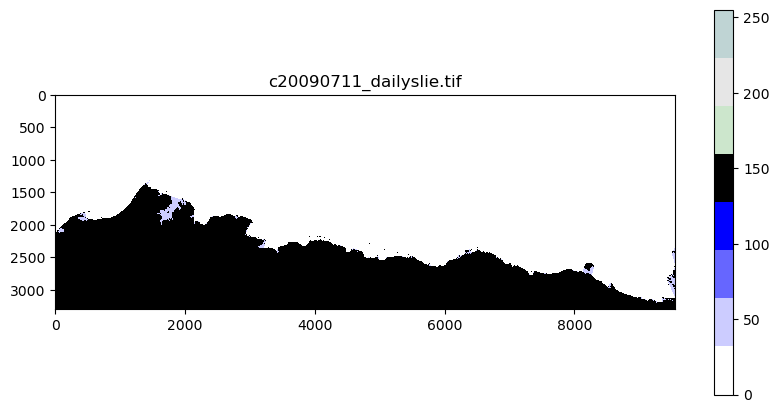

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2009-10
All metadata conforms.


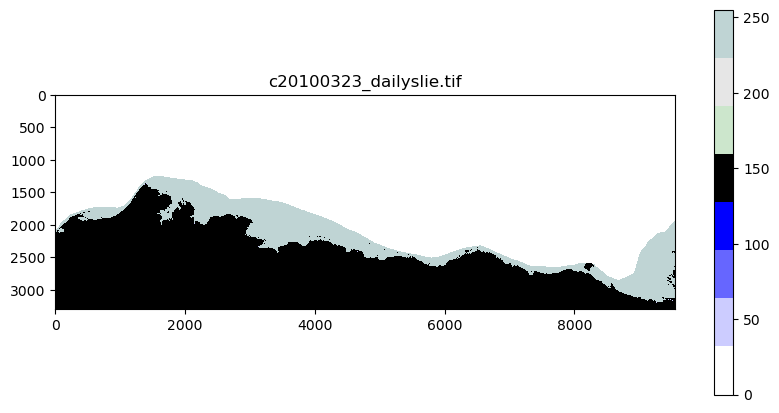

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2010-11
All metadata conforms.


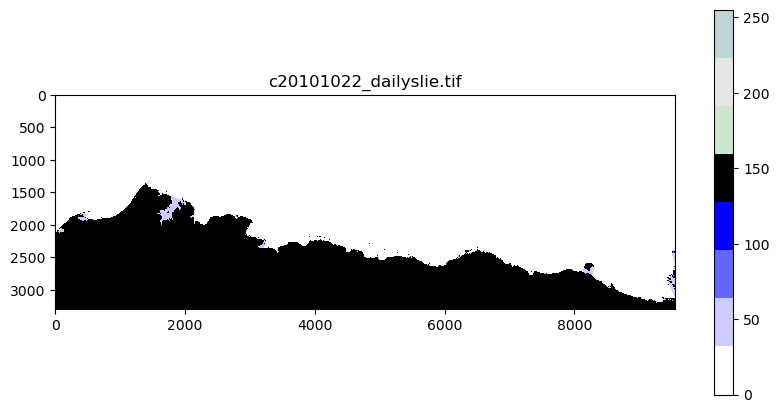

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2011-12
All metadata conforms.


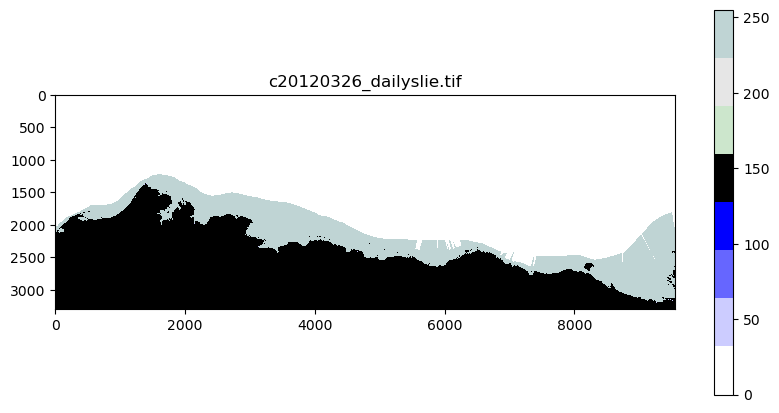

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2012-13
All metadata conforms.


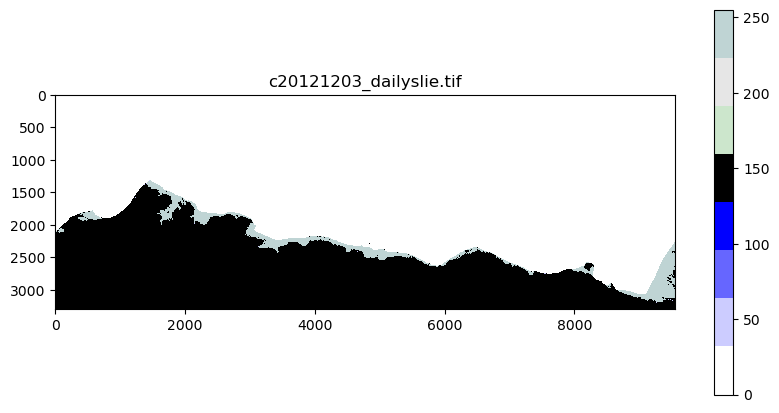

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2013-14
All metadata conforms.


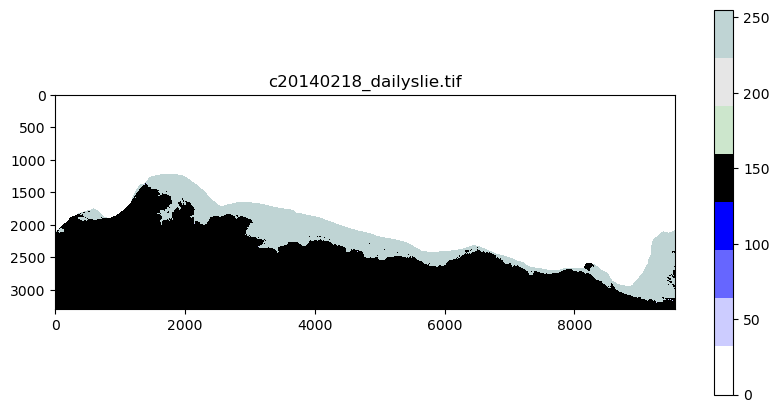

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2014-15
All metadata conforms.


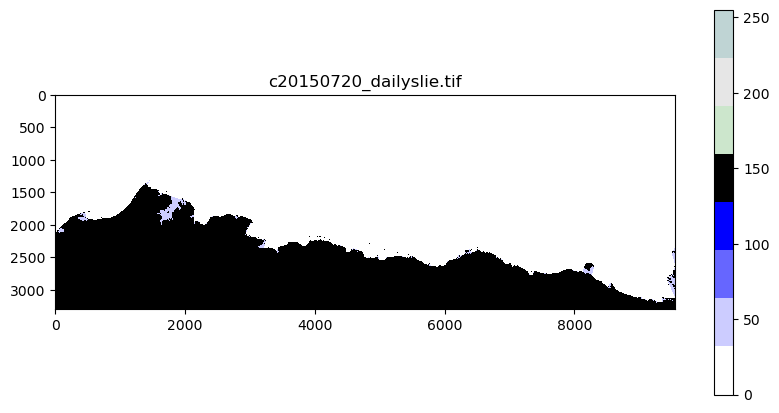

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2015-16
All metadata conforms.


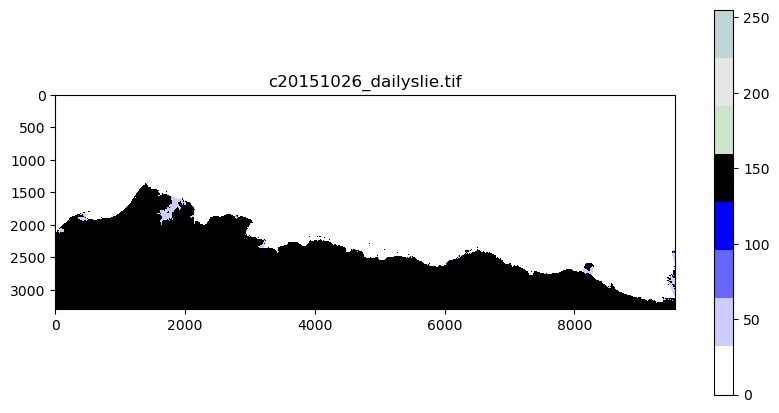

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2016-17
All metadata conforms.


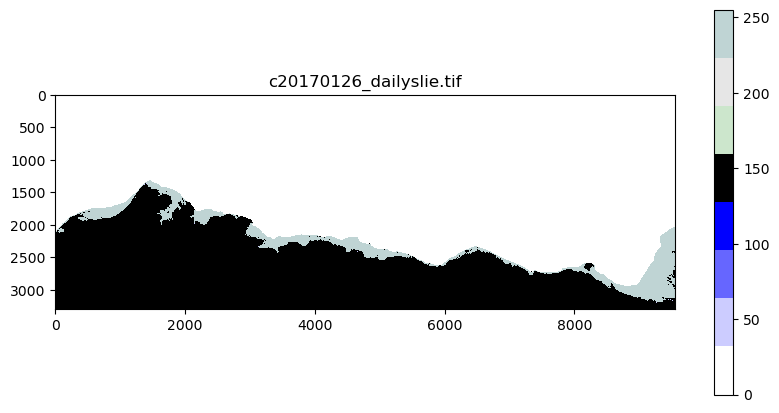

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2017-18
All metadata conforms.


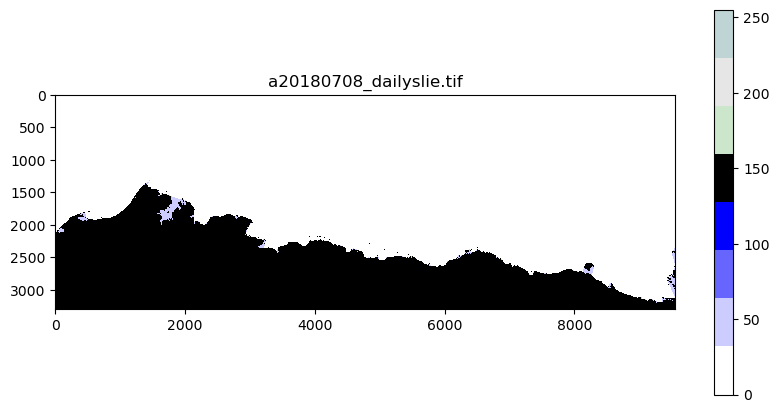

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2018-19
All metadata conforms.


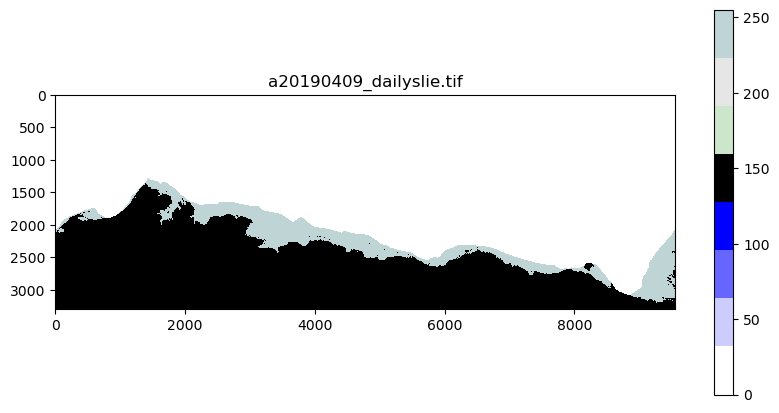

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2019-20
All metadata conforms.


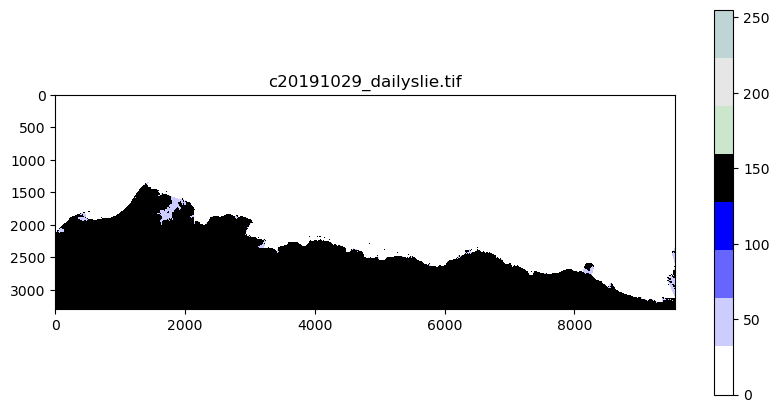

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2020-21
All metadata conforms.


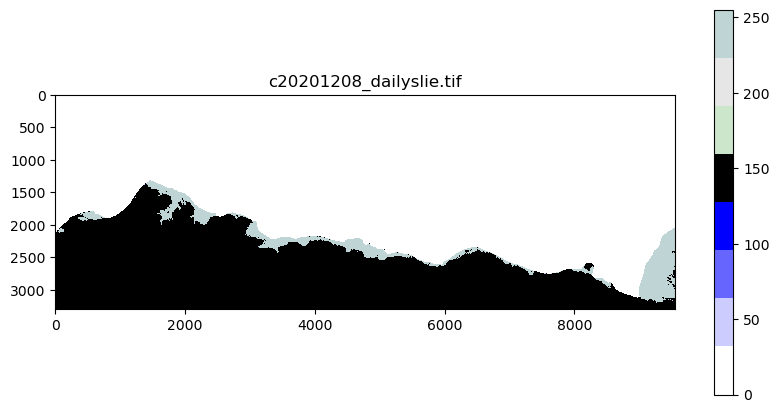

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2021-22
All metadata conforms.


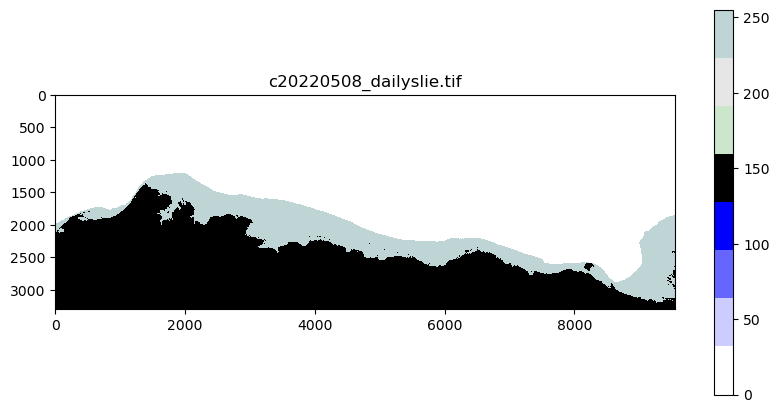

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Beau/2022-23
All metadata conforms.


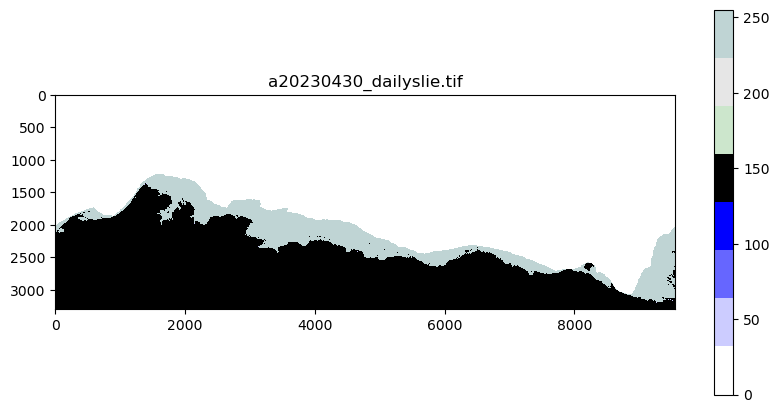

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/1996-97
All metadata conforms.


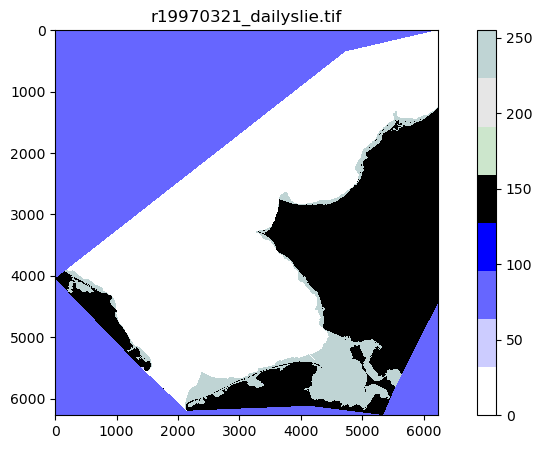

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/1997-98
All metadata conforms.


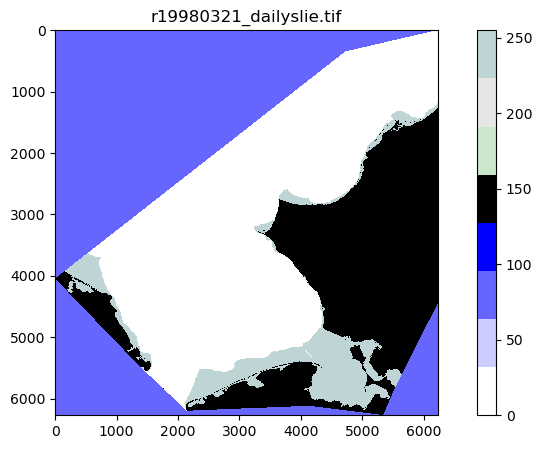

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/1998-99
All metadata conforms.


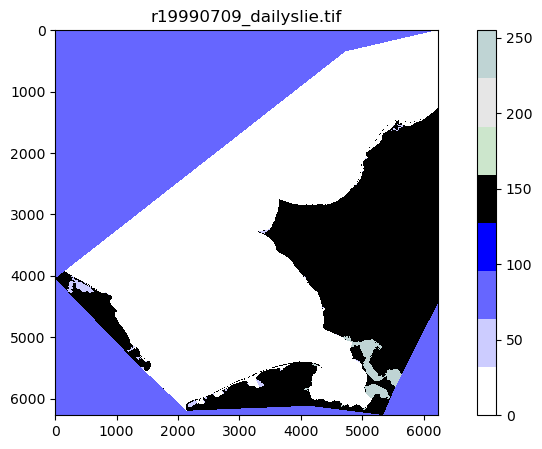

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/1999-00
All metadata conforms.


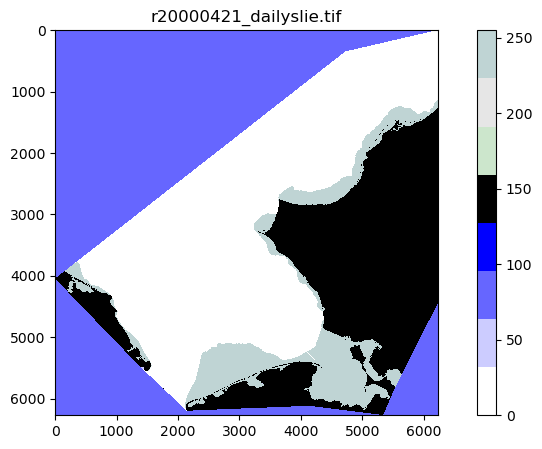

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2000-01
All metadata conforms.


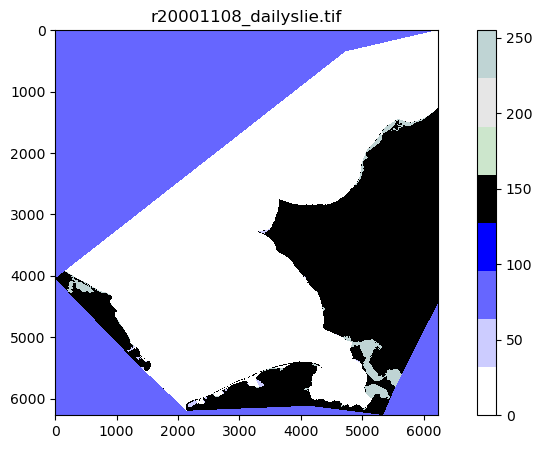

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2001-02
All metadata conforms.


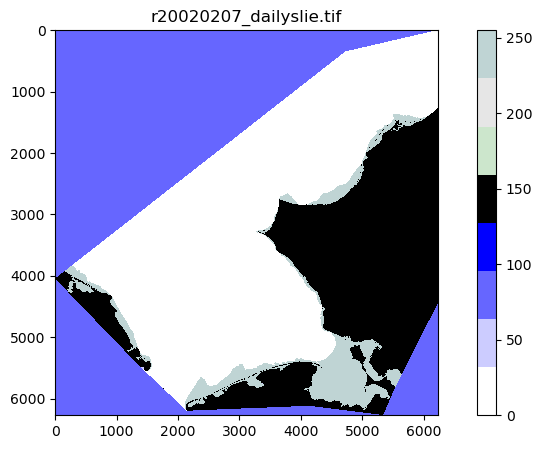

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2002-03
All metadata conforms.


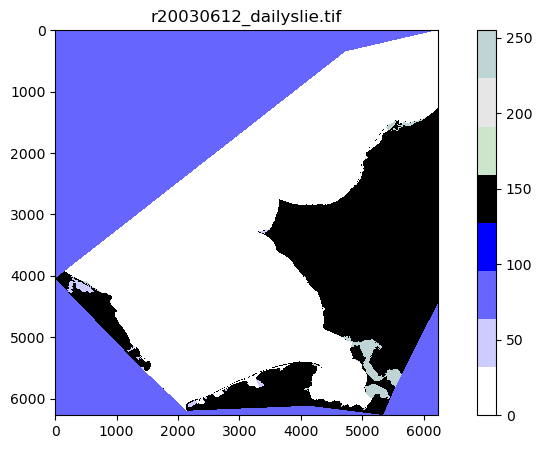

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2003-04
All metadata conforms.


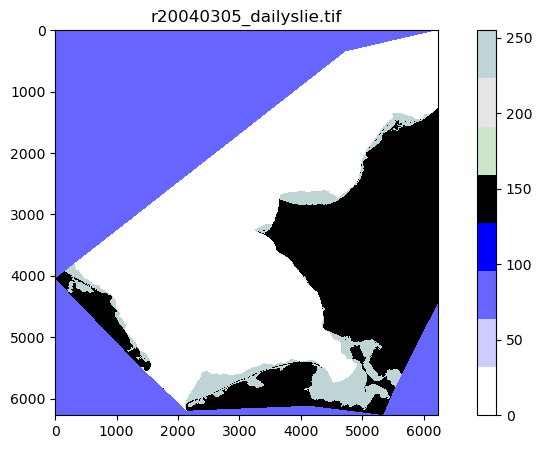

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2004-05
All metadata conforms.


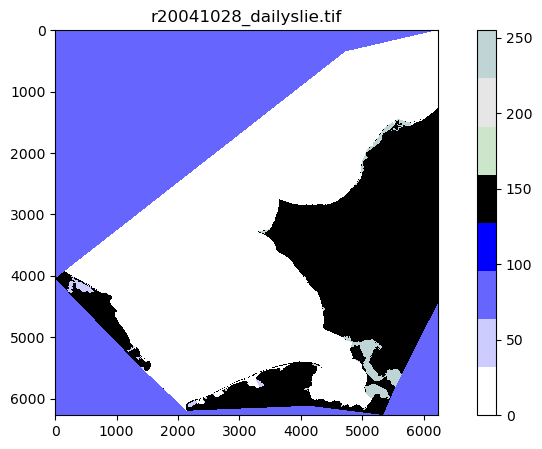

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2005-06
All metadata conforms.


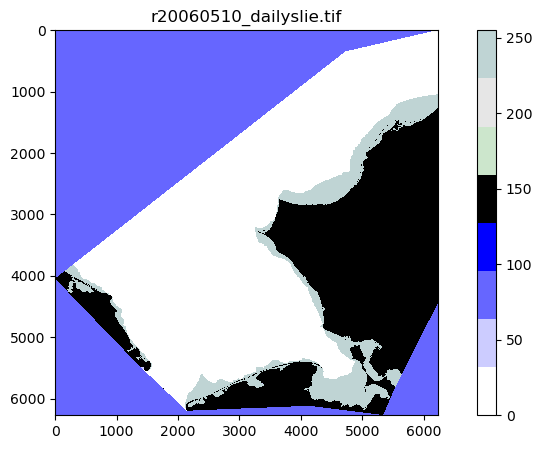

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2006-07
All metadata conforms.


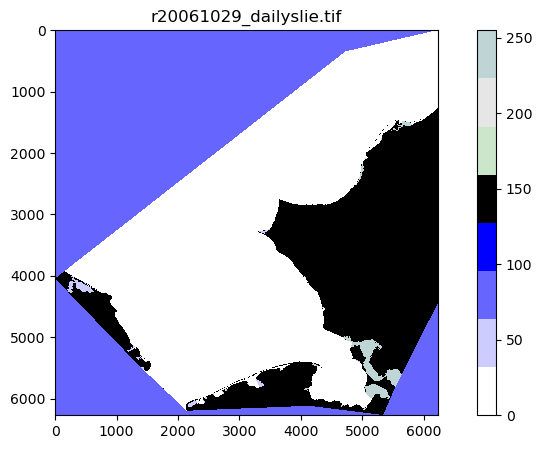

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2007-08
All metadata conforms.


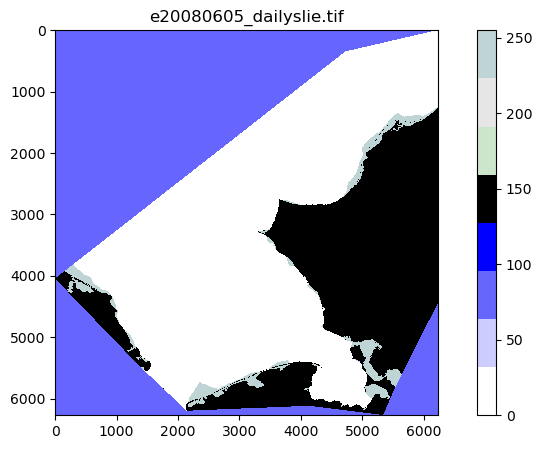

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2008-09
All metadata conforms.


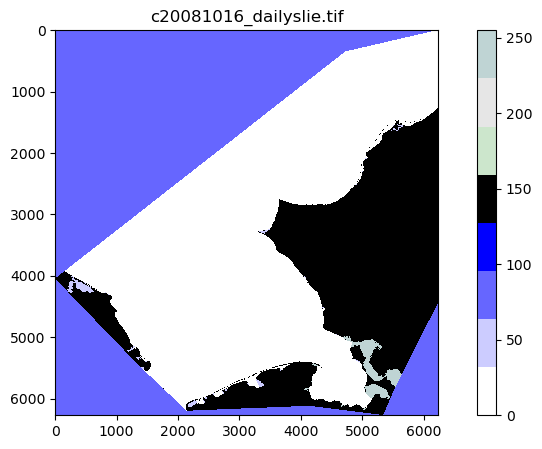

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2009-10
All metadata conforms.


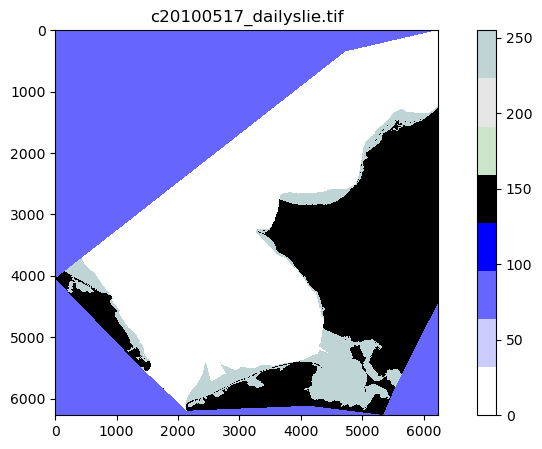

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2010-11
All metadata conforms.


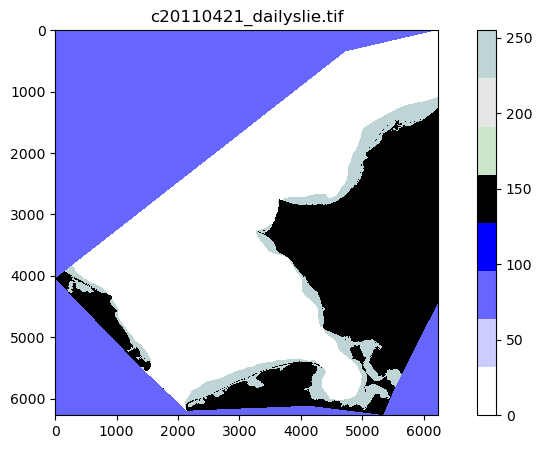

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2011-12
All metadata conforms.


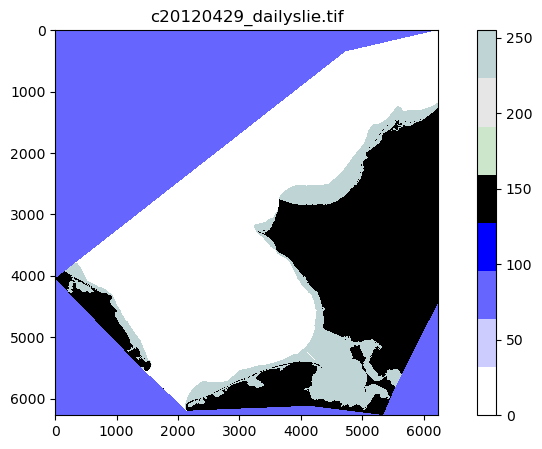

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2012-13
All metadata conforms.


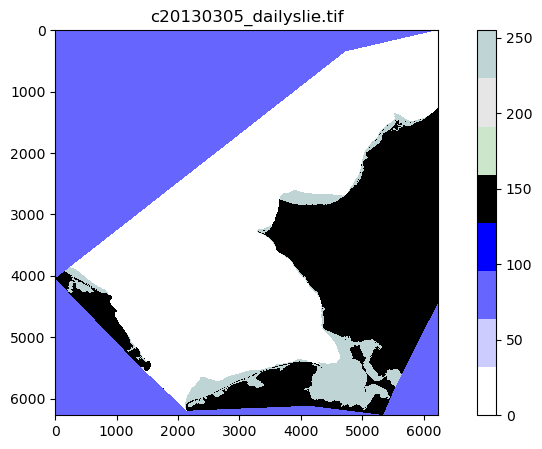

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2013-14
All metadata conforms.


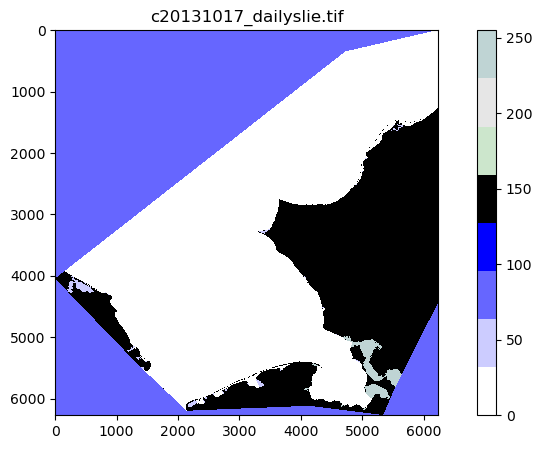

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2014-15
All metadata conforms.


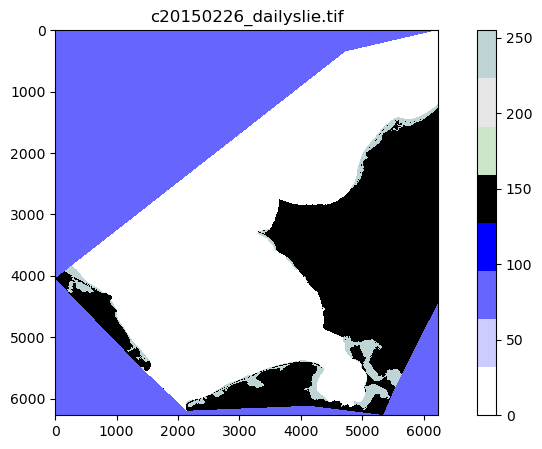

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2015-16
All metadata conforms.


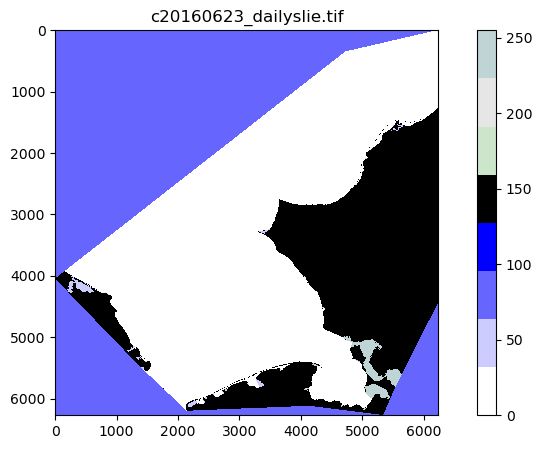

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2016-17
All metadata conforms.


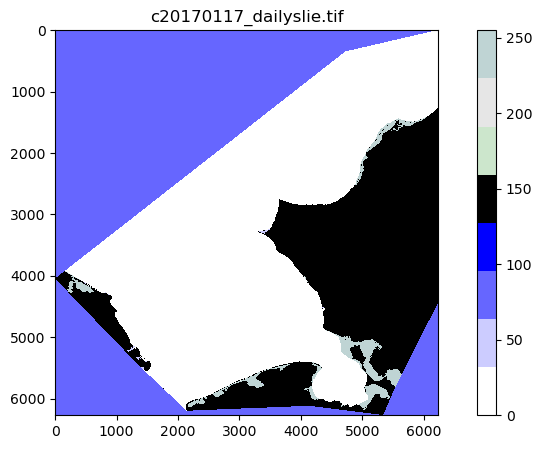

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2017-18
All metadata conforms.


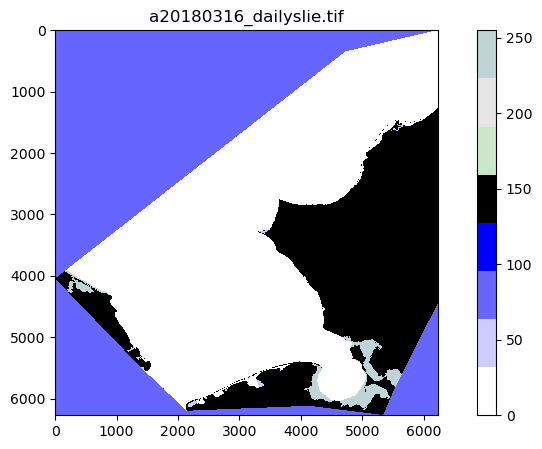

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2018-19
All metadata conforms.


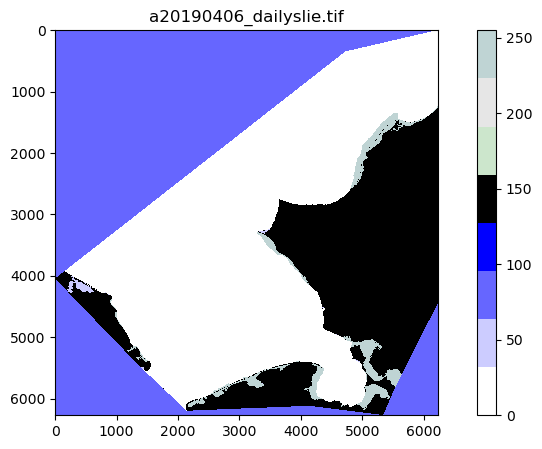

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2019-20
All metadata conforms.


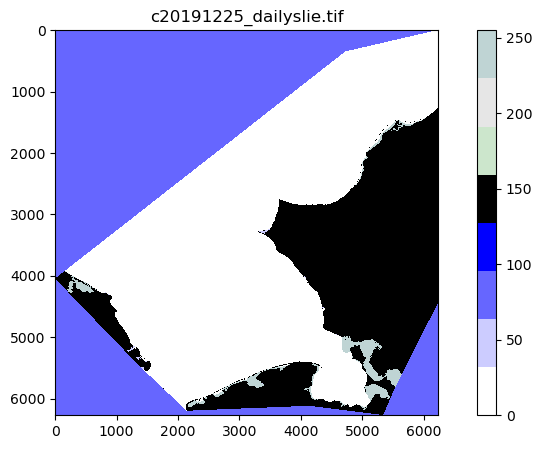

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2020-21
All metadata conforms.


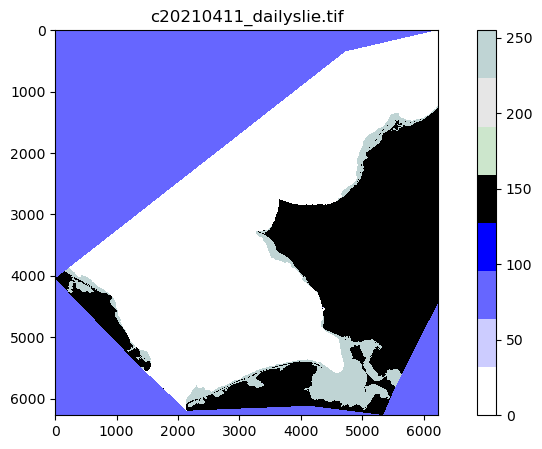

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2021-22
All metadata conforms.


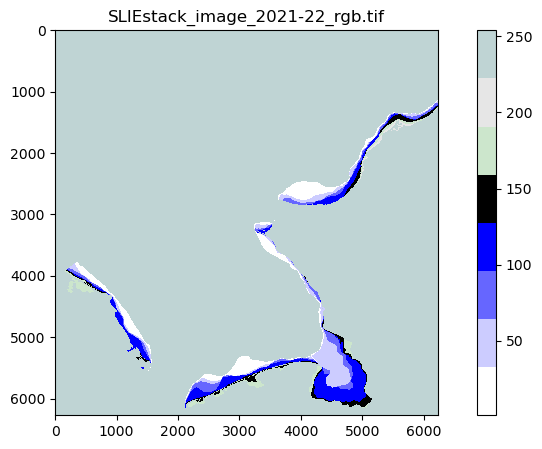

/atlas_scratch/cparr4/landfast_sea_ice/EM24/Chuk/2022-23
All metadata conforms.


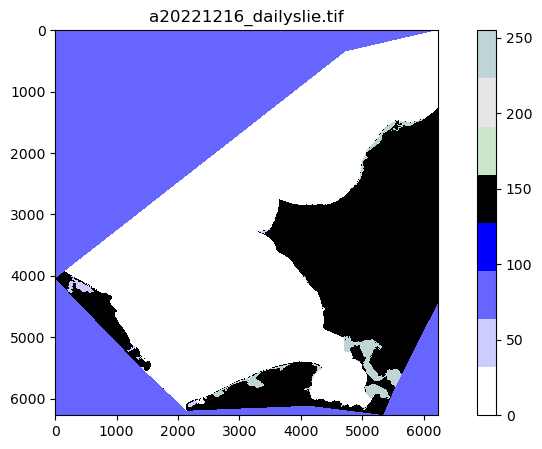

In [2]:
daily_slie_paths = []
for region in ice_zones:
    for year in ice_years:
        daily_slie_paths.append(Path(INPUT_FLAT_DIR / "EM24" / region / year))

for directory in daily_slie_paths:
    print(directory)
    eda.test_geotiff_metadata_for_conformity(directory, geotiff_metadata=None, str_to_match="dailyslie")
    eda.plot_random_sample(directory)

In [ ]:
geotiffs_to_ingest = []
metas = []

for region in ice_zones:
    for year in ice_years:
        target = Path(INPUT_FLAT_DIR / "EM24" / region / year)
        tiffs = eda.list_geotiffs(target, str_to_match="dailyslie")
        _, meta = eda.fetch_all_geotiff_metadata(target, str_to_match="dailyslie")
        geotiffs_to_ingest = geotiffs_to_ingest + tiffs
        metas = metas + meta
print(len(geotiffs_to_ingest))
geotiffs_to_ingest[0]

In [ ]:
metas[0]

In [ ]:
def rename(fp):
    if "Chuk" == fp.parent.parent.name:
        zone = "Chukchi"
        out_dir = DAILY_CHUKCHI_DIR
    elif "Beau" == fp.parent.parent.name:
        zone = "Beaufort"
        out_dir = DAILY_BEAUFORT_DIR
    else:
        print(fp)
    
    fname = fp.name
    yyyymmdd = fname.split("_")[0][1:]

    data_source_indicator = fname[0]
    source_str = data_sources[data_source_indicator].lower().replace(" ", "_")

    new_name = f"{zone.lower()}_{yyyymmdd}_{source_str}_slie.tif"
    new_fp = out_dir / new_name
    return new_fp

rename(geotiffs_to_ingest[0])

In [ ]:
def reproject_raster(file):

    dst_crs = rio.crs.CRS.from_epsg(3338)

    with rio.open(file) as src:

        # compute the new affine transformation, width and height
        warp_transform, width, height = rio.warp.calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        # define the output raster profile
        out_profile = src.profile.copy()
        out_profile.update(
            {
                "crs": dst_crs,
                "transform": warp_transform,
                "width": width,
                "height": height,
                "bounds": array_bounds(height, width, warp_transform),
            }
        )

        # create the new raster file
        out_file = rename(file)
        
        with rio.open(out_file, "w", **out_profile) as dst:
            # reproject the input raster data
            rio.warp.reproject(
                source=src.read(1),
                destination=rio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=warp_transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,  # NN is default, but explicit here for easy change or experimentation later
            )


In [ ]:
for tiff in geotiffs_to_ingest:
    reproject_raster(tiff)

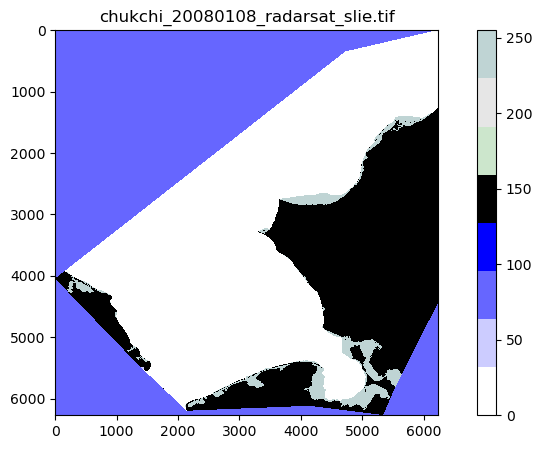

In [3]:
eda.plot_random_sample(DAILY_CHUKCHI_DIR)

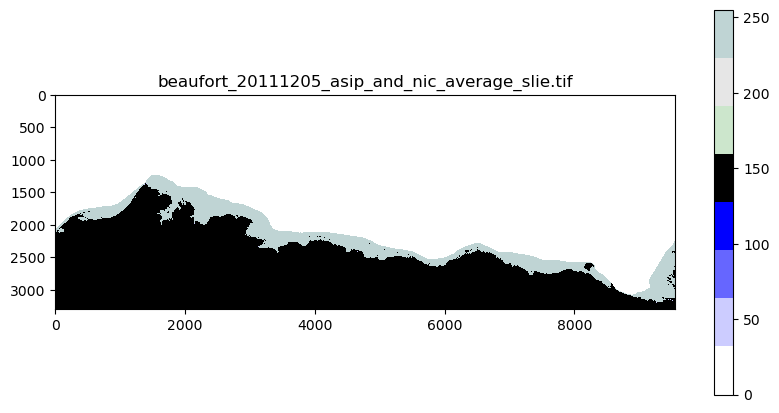

In [4]:
eda.plot_random_sample(DAILY_BEAUFORT_DIR)

In [ ]:
# number of files should 10 months * 3 era in each directory
assert len(eda.list_geotiffs(BEAUFORT_DIR)) == 30
assert len(eda.list_geotiffs(CHUKCHI_DIR)) == 30